In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,7)})

In [13]:
import sqlalchemy
import pandas as pd
import os
import datetime
from tqdm.notebook import tqdm as tqdm_notebook
#import mmh3
import seaborn as sns

from sqlalchemy import create_engine

from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq

from clickhouse_sqlalchemy import make_session
from urllib.parse import quote

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [14]:
def get_gbq_data(query):
    project = 'lentochka-9bb50' 
    credentials_bq = service_account.Credentials.from_service_account_file('lentochka.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],)
    pandas_gbq.context.credentials = credentials_bq
    pandas_gbq.context.project = project
    gbq_data = pandas_gbq.read_gbq(query, progress_bar_type=True)
    return gbq_data

In [3]:
password = 'dimVuidBun1onCub'
login = 'a.al.kosheleva'

def postre_auth(login, password):
    postgresql_config = {
    'postgresql_prefix' : 'postgresql'
    , 'postgresql_host'   : '10.3.26.92' 
    , 'postgresql_user'   : f'{login}'
    , 'postgresql_pass'   : f'{password}'
    , 'postgresql_port'   : '5432'
    , 'postgresql_db'     : 'dwh'    
    }

    postgresql_connection_string  = "{prefix}://{user}:{passw}@{host}:{port}/{db}".format(
    prefix  =   postgresql_config['postgresql_prefix']    , host  =   postgresql_config['postgresql_host']
    , user  =   postgresql_config['postgresql_user']      , passw =   postgresql_config['postgresql_pass']
    , port  =   postgresql_config['postgresql_port']      , db    =   postgresql_config['postgresql_db']
    )
    postgresql_engine = sqlalchemy.create_engine(postgresql_connection_string)
    postgresql_conn   = postgresql_engine.connect()
    return postgresql_engine, postgresql_conn

postrgre_engine, postrge_conn = postre_auth(login, password)

In [238]:
sql = '''SELECT distinct user_id 
FROM `lentochka-9bb50.reports.user_metrics_new` 
WHERE event_date = "2023-04-12" and any_active > 0
and user_id is not null and user_id != 'null'
'''
buyers = get_gbq_data(sql)

In [239]:
buyers_list = tuple(buyers.user_id.to_list())

In [240]:
old_users = f'''
select distinct buyer_id
from dwh_datamart.retention
where date(first_order) <= date(date('2023-04-14') - INTERVAL '90 day')
and buyer_id IN {buyers_list}
'''

In [241]:
old_users_list = pd.read_sql(old_users, postrge_conn)

In [242]:
buyers_list_fin = old_users_list.buyer_id.to_list()

In [243]:
#выгрузка текущая - для людей, зашедших 18 апреля
financial_data = f'''
with
orders AS (
select distinct buyer_id, pav_order_id, order_type, bill_amount
from dwh_datamart.ops_metrics
where date(created) between '2023-01-13' AND '2023-04-13'
and flag_cancel = 0 and order_source IN ('iOS', 'Android')
),

pcodes AS (
select distinct pav_order_id, action_id
from dwh_stage.utk_sess_utk_promocode_buyer_using
where date(created) between '2023-01-13' AND '2023-04-13'
),

orders_with_pcodes AS (
select buyer_id, o.pav_order_id, bill_amount,
       case when action_id is null then  0 else 1 end as pcode,
       case when order_type = 'Быстро' then 1 else 0 end as is_express
from orders o left join pcodes p on o.pav_order_id = p.pav_order_id
)

select buyer_id,
sum(bill_amount)/count(distinct pav_order_id) as avg_check,
sum(bill_amount) as revenue,
count(distinct pav_order_id) as frequency, round(sum(pcode)*1.00/count(distinct pav_order_id),2) as pcode_orders_percent,
round(sum(is_express)*1.00/count(distinct pav_order_id),2) as express_orders_percent
from orders_with_pcodes
group by 1;
'''

In [244]:
#выгрузка делалась 31 марта 2023 - нужно ставить в  orders >= date(date(now()) - INTERVAL '3 month')
categories_data = f'''
with cats AS (
select
  substr(mat.material,13,18)  original_id,
  wgh._0rpa_wgh2___t          cat_name
from dwh_stage.hadoop_bi0_pmaterial mat
inner join dwh_stage.hadoop_bic_rpa_wgh wgh
on mat.rpa_wgh4 = wgh._0rpa_wgh4
where rpa_wgh2 != '99'
and wgh._0rpa_wgh2___t != 'Резервная группа'
group by 1,2),

orders AS (
select distinct buyer_id, pav_order_id
from dwh_datamart.ops_metrics
where date(created) between '2023-01-13' AND '2023-04-13'
and flag_cancel = 0 and order_source IN ('iOS', 'Android')
),

t1 as (
select
  buyer_id,
  cat_name,
  count_courier*zit.denominator/zit.numerator as number,
  sum(count_courier*zit.denominator/zit.numerator) over (partition by buyer_id) as count_items_total
from orders z
inner join dwh_stage.utk_sess_zakaz_items zit
on zit.pav_order_id = z.pav_order_id
left join cats c on zit.original_id = c.original_id
)

select buyer_id, cat_name, sum(number)*1.00/max(count_items_total) percent_cat
from t1
where count_items_total > 0
group by 1,2
'''

In [245]:
financial_df = pd.read_sql(financial_data, postrge_conn)

In [246]:
financial_df

,buyer_id,avg_check,revenue,frequency,pcode_orders_percent,express_orders_percent
0,94025409,3232.310000,3232.31,1,1.0,0.00
1,94115028,2646.743333,7940.23,3,0.0,0.33
2,94578440,2262.170000,6786.51,3,1.0,0.00
3,94578442,2080.885000,4161.77,2,1.0,0.00
4,94578475,3286.768000,65735.36,20,1.0,0.20
...,...,...,...,...,...,...
712241,105195615,1739.340000,1739.34,1,1.0,0.00
712242,105195636,1261.440000,1261.44,1,1.0,0.00
712243,105195671,1385.320000,1385.32,1,1.0,0.00
712244,105195703,1057.280000,1057.28,1,1.0,0.00


In [ ]:
categories_df = pd.read_sql(categories_data, postrge_conn)

In [ ]:
categories_df

In [ ]:
financial_df = pd.DataFrame(financial_df.query("buyer_id == @buyers_list_fin"))

In [ ]:
categories_df = pd.DataFrame(categories_df.query("buyer_id == @buyers_list_fin"))

In [ ]:
categories_df_pivot = pd.pivot_table(categories_df, values='percent_cat', index=['buyer_id'],
                    columns=['cat_name'], aggfunc=np.sum).reset_index()

In [ ]:
categories_df_pivot

In [ ]:
categories_df_pivot.buyer_id.nunique()

In [ ]:
financial_df.buyer_id.nunique()

In [ ]:
final_df = categories_df_pivot.merge(financial_df, on = 'buyer_id', how = 'inner')

In [ ]:
final_df = final_df.fillna(0)

In [ ]:
final_df_sample = final_df.sample(n=30000, random_state=1)

In [ ]:
final_df_sample.reset_index(drop= True , inplace= True )

In [ ]:
#final_df_sample.to_excel('final_df_sample.xlsx')

In [ ]:
column_headers = list(final_df_sample.columns.values)

In [ ]:
column_headers

In [ ]:
# преобразуем датафрейм для кластеризации (убираем тяжелые хвосты в метриках)
def get_log_df(data):
    def log_transform(v): 
        res = np.log(v+1)
        return res
    
    data_tmp = data.copy()
    for el in ['Автотовары',
 'Аксессуары и галантерея',
 'Аудио, видео, цифровая техника и аксессу',
 'Багаж',
 'Бакалея',
 'Безалкогольные напитки',
 'Бытовая техника',
 'Бытовая химия, хозяйственные товары',
 'Вино',
 'Гигиенические средства',
 'Деликатесы из рыбы и морепродуктов',
 'Детская гигиена',
 'Детская одежда, обувь и постельные прин',
 'Детское питание',
 'Женская и мужская одежда',
 'Женское и мужское нижнее белье',
 'Живые горшечные цветы, срезка',
 'Закуски к аперитивам',
 'Замороженная рыба',
 'Игрушки',
 'Канцелярия и печатная продукция',
 'Консервы',
 'Косметика и аксессуары',
 'Кофе, какао, чай',
 'Кулинария собственного производства',
 'Майонезы, Закуски, Готовые Блюда охл',
 'Масложировая продукция',
 'Молочные продукты д/детского питания',
 'Морепродукты глубокой заморозки',
 'Мясо глубокой заморозки',
 'Мясо охлажденное',
 'Не шоколадные кондитерские изделия',
 'Овощи',
 'Одежда и товары для новорождённых',
 'Охлажденная и переработанная рыбная прод',
 'П\\ф и другие продукты глубокой заморзк',
 'Пекарня промышленное производство',
 'Пекарня собственное производство',
 'Пиво и слабоалкогольные напитки',
 'Посуда столовая, товары для дома',
 'Продукты мясной переработки',
 'Профессиональные Товары для животных',
 'Птица глубокой заморозки',
 'Птица охлажденная',
 'Современная молочная продукция',
 'Спорт, туризм',
 'Средства персонального ухода',
 'Сыры',
 'Табачные изделия',
 'Текстиль для дома',
 'Товары для акции лояльности КС',
 'Товары для животных',
 'Товары для приготовления',
 'Товары для сада',
 'Товары для уборки и хранения',
 'Товары сделай сам (DIY)',
 'Традиционная молочная продукция',
 'Фрукты',
 'Функциональное питание',
 'Шоколадные кондитерские изделия',
 'Электротовары',
 'Яйцо']:
        data_tmp[el] = data_tmp[el].apply(lambda x: log_transform(x))
    return data_tmp[['Автотовары',
 'Аксессуары и галантерея',
 'Аудио, видео, цифровая техника и аксессу',
 'Багаж',
 'Бакалея',
 'Безалкогольные напитки',
 'Бытовая техника',
 'Бытовая химия, хозяйственные товары',
 'Вино',
 'Гигиенические средства',
 'Деликатесы из рыбы и морепродуктов',
 'Детская гигиена',
 'Детская одежда, обувь и постельные прин',
 'Детское питание',
 'Женская и мужская одежда',
 'Женское и мужское нижнее белье',
 'Живые горшечные цветы, срезка',
 'Закуски к аперитивам',
 'Замороженная рыба',
 'Игрушки',
 'Канцелярия и печатная продукция',
 'Консервы',
 'Косметика и аксессуары',
 'Кофе, какао, чай',
 'Кулинария собственного производства',
 'Майонезы, Закуски, Готовые Блюда охл',
 'Масложировая продукция',
 'Молочные продукты д/детского питания',
 'Морепродукты глубокой заморозки',
 'Мясо глубокой заморозки',
 'Мясо охлажденное',
 'Не шоколадные кондитерские изделия',
 'Овощи',
 'Одежда и товары для новорождённых',
 'Охлажденная и переработанная рыбная прод',
 'П\\ф и другие продукты глубокой заморзк',
 'Пекарня промышленное производство',
 'Пекарня собственное производство',
 'Пиво и слабоалкогольные напитки',
 'Посуда столовая, товары для дома',
 'Продукты мясной переработки',
 'Профессиональные Товары для животных',
 'Птица глубокой заморозки',
 'Птица охлажденная',
 'Современная молочная продукция',
 'Спорт, туризм',
 'Средства персонального ухода',
 'Сыры',
 'Табачные изделия',
 'Текстиль для дома',
 'Товары для акции лояльности КС',
 'Товары для животных',
 'Товары для приготовления',
 'Товары для сада',
 'Товары для уборки и хранения',
 'Товары сделай сам (DIY)',
 'Традиционная молочная продукция',
 'Фрукты',
 'Функциональное питание',
 'Шоколадные кондитерские изделия',
 'Электротовары',
 'Яйцо']]

In [ ]:
df_log = get_log_df(final_df_sample.copy())

In [ ]:
df_log.head()

Мин-макс шкалирование

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#нормализуем данные, приведем к одной шкале
df_log_sc = MinMaxScaler().fit_transform(df_log)

In [ ]:
df_log_sc.shape

In [ ]:
df_log_sc_clmns = pd.DataFrame(df_log_sc)

In [ ]:
df_log_sc_clmns.columns = df_log.columns

Сохраняем tSNE отображение

In [ ]:
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.manifold import TSNE

In [ ]:
tsne_representation = TSNE(n_components=2, random_state=321).fit_transform(df_log_sc)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [ ]:
distance_matrix = linkage(tsne_representation, method = 'ward', metric = 'euclidean')

In [ ]:
from scipy.cluster.hierarchy import dendrogram

In [ ]:
dn = dendrogram(
        distance_matrix,
        leaf_rotation=90.,
        leaf_font_size=8.,
        truncate_mode='level',
        p=16,
        color_threshold=100,
        no_labels=True
    )

In [ ]:
#итого было выбрано взять 10 кластеров, далее будет график и подсчет средних значений
cl_tsne_labels_final = pd.Series(fcluster(distance_matrix, 10, criterion='maxclust'))

In [ ]:
cl_tsne_labels_final_agg = cl_tsne_labels_final

In [ ]:
clusters_df = pd.DataFrame({
    'cl_tsne_labels_final':cl_tsne_labels_final,
    'cl_tsne_labels_final_agg':cl_tsne_labels_final,
    'x':tsne_representation[:,0],
    'y':tsne_representation[:,1]
}
)

In [ ]:
import matplotlib.cm as cm
def get_clusters_image(l):
    clusters_df = pd.DataFrame({
        'cl_tsne_labels_final_agg':l,
        'x':tsne_representation[:,0],
        'y':tsne_representation[:,1]
    }
    )
    colors = cm.rainbow(np.linspace(0,1,len(set(l))))
    for y, c in zip(set(l), colors):
        plt.scatter(tsne_representation[pd.Series(l).values==y, 0], 
                    tsne_representation[pd.Series(l).values==y, 1], c=c, alpha=0.3, label=str(y))
    return plt.legend()

In [ ]:
get_clusters_image(cl_tsne_labels_final_agg)

In [ ]:
final_df_sample["labels_10"] = cl_tsne_labels_final_agg

In [ ]:
final_df_sample

In [ ]:
df_vis = final_df_sample[['Автотовары',
 'Аксессуары и галантерея',
 'Аудио, видео, цифровая техника и аксессу',
 'Багаж',
 'Бакалея',
 'Безалкогольные напитки',
 'Бытовая техника',
 'Бытовая химия, хозяйственные товары',
 'Вино',
 'Гигиенические средства',
 'Деликатесы из рыбы и морепродуктов',
 'Детская гигиена',
 'Детская одежда, обувь и постельные прин',
 'Детское питание',
 'Женская и мужская одежда',
 'Женское и мужское нижнее белье',
 'Живые горшечные цветы, срезка',
 'Закуски к аперитивам',
 'Замороженная рыба',
 'Игрушки',
 'Канцелярия и печатная продукция',
 'Консервы',
 'Косметика и аксессуары',
 'Кофе, какао, чай',
 'Кулинария собственного производства',
 'Майонезы, Закуски, Готовые Блюда охл',
 'Масложировая продукция',
 'Молочные продукты д/детского питания',
 'Морепродукты глубокой заморозки',
 'Мясо глубокой заморозки',
 'Мясо охлажденное',
 'Не шоколадные кондитерские изделия',
 'Овощи',
 'Одежда и товары для новорождённых',
 'Охлажденная и переработанная рыбная прод',
 'П\\ф и другие продукты глубокой заморзк',
 'Пекарня промышленное производство',
 'Пекарня собственное производство',
 'Пиво и слабоалкогольные напитки',
 'Посуда столовая, товары для дома',
 'Продукты мясной переработки',
 'Профессиональные Товары для животных',
 'Птица глубокой заморозки',
 'Птица охлажденная',
 'Современная молочная продукция',
 'Спорт, туризм',
 'Средства персонального ухода',
 'Сыры',
 'Табачные изделия',
 'Текстиль для дома',
 'Товары для акции лояльности КС',
 'Товары для животных',
 'Товары для приготовления',
 'Товары для сада',
 'Товары для уборки и хранения',
 'Товары сделай сам (DIY)',
 'Традиционная молочная продукция',
 'Фрукты',
 'Функциональное питание',
 'Шоколадные кондитерские изделия',
 'Электротовары',
 'Яйцо',
 'avg_check',
 'revenue',
 'frequency',
 'pcode_orders_percent',
 'express_orders_percent',
 'labels_10']].copy()

In [ ]:
df_vis_pivot = df_vis.pivot_table(index='labels_10', aggfunc='mean').transpose().reset_index()

In [ ]:
df_vis_pivot.to_excel('clasters_14_apr.xlsx')

In [ ]:
final_df_sample.groupby('labels_10')['buyer_id'].nunique()

In [52]:
age_and_sex = '''
select o.buyer_id, extract('year' from date(now())) - extract('year' from date(bdate)) as age, 
       case when sex = 1 then 0 
            else 1 end as sex
from dwh_datamart.ops_metrics o left join dwh_stage.utk_sess_session_bonus p
on o.buyer_id = p.buyer_id
where date between '2022-03-26' and '2023-03-26'
and flag_cancel = 0
and order_source IN ('iOS', 'Android')
and sex != 0
and bdate is not null
group by 1,2,3
'''

In [53]:
demographics = pd.read_sql(age_and_sex, postrge_conn)

In [54]:
demographics

,buyer_id,age,sex
0,94025409,36.0,0
1,94205486,31.0,1
2,94578440,25.0,0
3,94578442,38.0,0
4,94578489,34.0,1
...,...,...,...
287902,104938305,47.0,0
287903,104938505,26.0,1
287904,104938671,52.0,1
287905,104938714,61.0,0


In [55]:
additional = final_df_sample.merge(demographics, on = 'buyer_id', how = 'inner')

In [56]:
additional

,buyer_id,Автотовары,Аксессуары и галантерея,"Аудио, видео, цифровая техника и аксессу",Багаж,Бакалея,Безалкогольные напитки,Бытовая техника,"Бытовая химия, хозяйственные товары",Вино,...,Электротовары,Яйцо,avg_check,revenue,frequency,pcode_orders_percent,express_orders_percent,labels_10,age,sex
0,103330000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.024718,3376.030000,3376.03,1,1.00,0.00,1,42.0,1
1,96891201,0.0,0.0,0.0,0.0,0.047923,0.000000,0.0,0.019169,0.0,...,0.0,0.000000,2155.326667,6465.98,3,0.67,0.00,2,36.0,1
2,95223557,0.0,0.0,0.0,0.0,0.043177,0.071513,0.0,0.009445,0.0,...,0.0,0.000000,2840.911667,51136.41,18,0.56,0.00,8,34.0,1
3,97602945,0.0,0.0,0.0,0.0,0.053479,0.000000,0.0,0.073534,0.0,...,0.0,0.040109,6723.440000,13446.88,2,0.00,0.00,6,33.0,1
4,95925823,0.0,0.0,0.0,0.0,0.103793,0.065553,0.0,0.065553,0.0,...,0.0,0.010926,1644.107143,23017.50,14,0.00,0.29,7,26.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9135,95030190,0.0,0.0,0.0,0.0,0.086024,0.090940,0.0,0.034410,0.0,...,0.0,0.012289,1772.547826,40768.60,23,0.26,0.00,7,33.0,1
9136,97124178,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,1189.640000,1189.64,1,0.00,0.00,2,31.0,1
9137,96719933,0.0,0.0,0.0,0.0,0.054801,0.024749,0.0,0.019445,0.0,...,0.0,0.010607,2068.651905,43441.69,21,0.43,0.00,2,30.0,1
9138,96270167,0.0,0.0,0.0,0.0,0.028060,0.016034,0.0,0.124267,0.0,...,0.0,0.000000,1673.203333,15058.83,9,0.11,0.00,2,38.0,1


In [59]:
pd.DataFrame(additional.pivot_table(index='labels_10', aggfunc='mean'))[['sex']].transpose()

labels_10,1,2,3,4,5,6,7,8,9,10
sex,0.819913,0.885496,0.855,0.820652,0.828092,0.823467,0.824468,0.900198,0.798137,0.777209


In [54]:
df_vis.head(2)

,Автотовары,Аксессуары и галантерея,"Аудио, видео, цифровая техника и аксессу",Багаж,Бакалея,Безалкогольные напитки,Бытовая техника,"Бытовая химия, хозяйственные товары",Вино,Гигиенические средства,...,Функциональное питание,Шоколадные кондитерские изделия,Электротовары,Яйцо,avg_check,revenue,frequency,pcode_orders_percent,express_orders_percent,labels_10
0,0.0,0.0,0.0,0.0,0.071357,0.089197,0.0,0.089197,0.0,0.071357,...,0.0,0.036678,0.0,0.017839,3899.8225,15599.29,4,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.085596,0.000000,0.0,0.028532,0.0,0.000000,...,0.0,0.000000,0.0,0.057064,1704.1350,3408.27,2,0.5,0.0,4


Детское питание


<AxesSubplot:xlabel='labels_10', ylabel='Детское питание'>

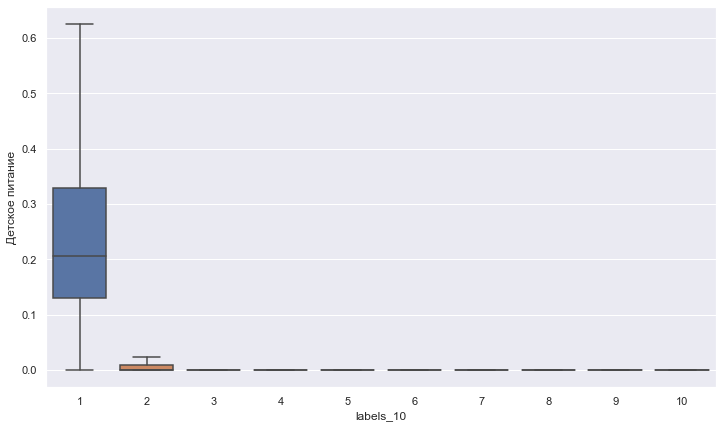

In [55]:
print("Детское питание")
sns.boxplot(x="labels_10", y="Детское питание", data=df_vis, showfliers = False)

Товары для животных


<AxesSubplot:xlabel='labels_10', ylabel='Товары для животных'>

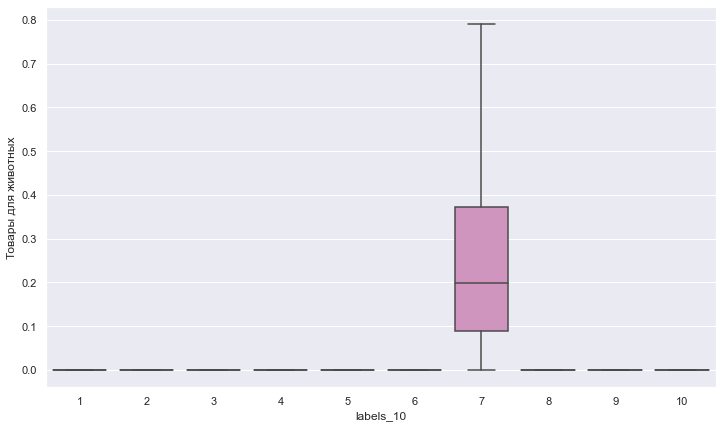

In [56]:
print("Товары для животных")
sns.boxplot(x="labels_10", y="Товары для животных", data=df_vis, showfliers = False)

In [63]:
sns.distplot(y="Товары для животных", data=)

TypeError: distplot() got an unexpected keyword argument 'y'

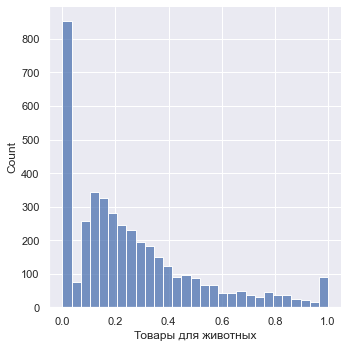

In [64]:
sns.displot(data=final_df_sample[final_df_sample.labels_10 == 7], x="Товары для животных")

Овощи


<AxesSubplot:xlabel='labels_10', ylabel='Овощи'>

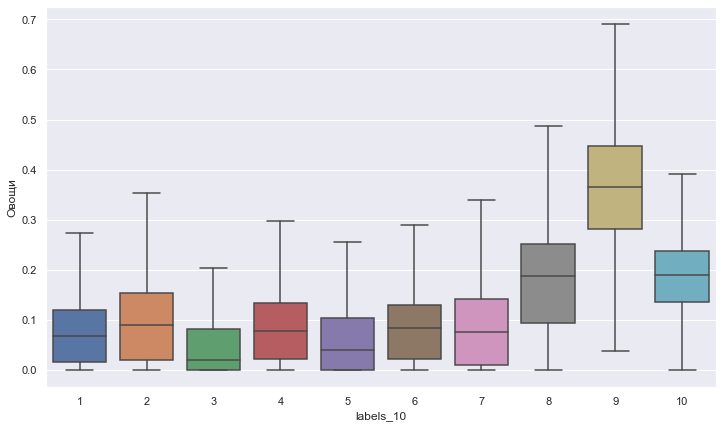

In [57]:
print("Овощи")
sns.boxplot(x="labels_10", y="Овощи", data=df_vis, showfliers = False)

Фрукты


<AxesSubplot:xlabel='labels_10', ylabel='Фрукты'>

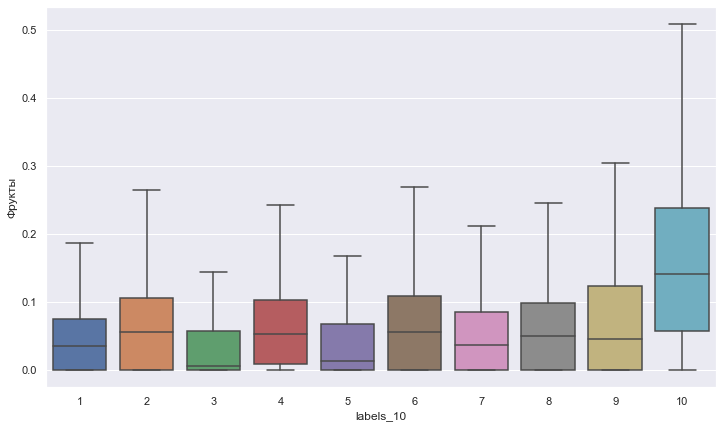

In [58]:
print("Фрукты")
sns.boxplot(x="labels_10", y="Фрукты", data=df_vis, showfliers = False)